In [8]:
import akshare as ak
import arrow
import datetime
import pandas as pd
from alphalens.utils import get_clean_factor_and_forward_returns

df = ak.index_stock_cons_csindex(symbol="000300")
secs = df["成分券代码"]

合并收盘价和换手率，以便找出每日最低换手率

In [3]:
from typing import List

def prepare_data(secs: List[str], start: datetime.date, end: datetime.date):
    factors = []
    prices = []

    start_ = arrow.get(start).format("YYYYMMDD")
    end_ = arrow.get(end).format("YYYYMMDD")

    for sec in secs:
        bars = ak.stock_zh_a_hist(sec, adjust="qfq", start_date=start_, end_date=end_)
        bars["asset"] = [sec] * len(bars)
        prices.append(bars[["日期", "asset", "收盘"]])

        factors.append(bars[["日期", "asset", "换手率"]])

    # 处理因子表
    factor = pd.concat(factors)
    factor.rename(columns = {"换手率":"factor", "日期":"date"}, inplace=True)
    factor["date"] = pd.to_datetime(factor["date"], utc=True)
    factor.set_index(["date", "asset"], inplace=True)

    # 处理prices表格
    prices = pd.concat(prices).pivot(index="日期", columns="asset", values="收盘")

    # 价格表index类型转换： str -> date
    prices.index = pd.to_datetime(prices.index, utc=True)

    # 价格表index名字必须转换为'date'
    prices.rename_axis('date', inplace=True)


    return factor, prices
    
start = datetime.date(2023, 1, 3)
end = datetime.date(2023, 12, 31)
factor, prices = prepare_data(secs, start, end)

In [9]:
factor_data = get_clean_factor_and_forward_returns(factor, prices, bins=10, quantiles=None)
factor_data.groupby("factor_quantile").count()

Dropped 4.1% entries from factor data: 4.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


,1D,5D,10D,factor
factor_quantile,,,,
1,40294,40294,40294,40294
2,17986,17986,17986,17986
3,5969,5969,5969,5969
4,2446,2446,2446,2446
5,1205,1205,1205,1205
6,515,515,515,515
7,369,369,369,369
8,281,281,281,281
9,164,164,164,164


In [ ]:
from alphalens.utils import get_clean_factor_and_forward_returns

factor_data = get_clean_factor_and_forward_returns(factor, prices, bins=None, quantiles=10)
factor_data.groupby("factor_quantile").mean()

Dropped 4.1% entries from factor data: 4.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


,1D,5D,10D,factor
factor_quantile,,,,
1,0.000282,0.001210,0.002412,0.134719
2,-0.000024,-0.000839,-0.000739,0.244580
3,-0.000355,-0.001357,-0.002082,0.331533
4,-0.000372,-0.001734,-0.002705,0.418632
5,-0.000157,-0.001909,-0.003790,0.514792
6,-0.000123,-0.002420,-0.005460,0.640887
7,-0.000648,-0.002914,-0.006666,0.811800
8,-0.000718,-0.004199,-0.009153,1.066287
9,-0.001183,-0.004689,-0.008731,1.544363


In [11]:
from alphalens.performance import mean_return_by_quantile

mean_return_by_q_daily, std_err = mean_return_by_quantile(
    factor_data, by_date=True)

mean_return_by_q_daily

1D        5D       10D
factor_quantile date                                                   
1               2023-01-03 00:00:00+00:00 -0.009207  0.010897 -0.008567
                2023-01-04 00:00:00+00:00  0.008673  0.006465 -0.005555
                2023-01-05 00:00:00+00:00  0.002533 -0.000497  0.002351
                2023-01-06 00:00:00+00:00 -0.001323 -0.016166 -0.013959
                2023-01-09 00:00:00+00:00  0.004395 -0.004391  0.008561
...                                             ...       ...       ...
10              2023-12-11 00:00:00+00:00  0.003648  0.012043  0.018105
                2023-12-12 00:00:00+00:00  0.002020  0.007315  0.018383
                2023-12-13 00:00:00+00:00  0.000786  0.014730  0.018263
                2023-12-14 00:00:00+00:00 -0.003310  0.004055 -0.000894
                2023-12-15 00:00:00+00:00  0.008244  0.011524 -0.001455

[2320 rows x 3 columns]

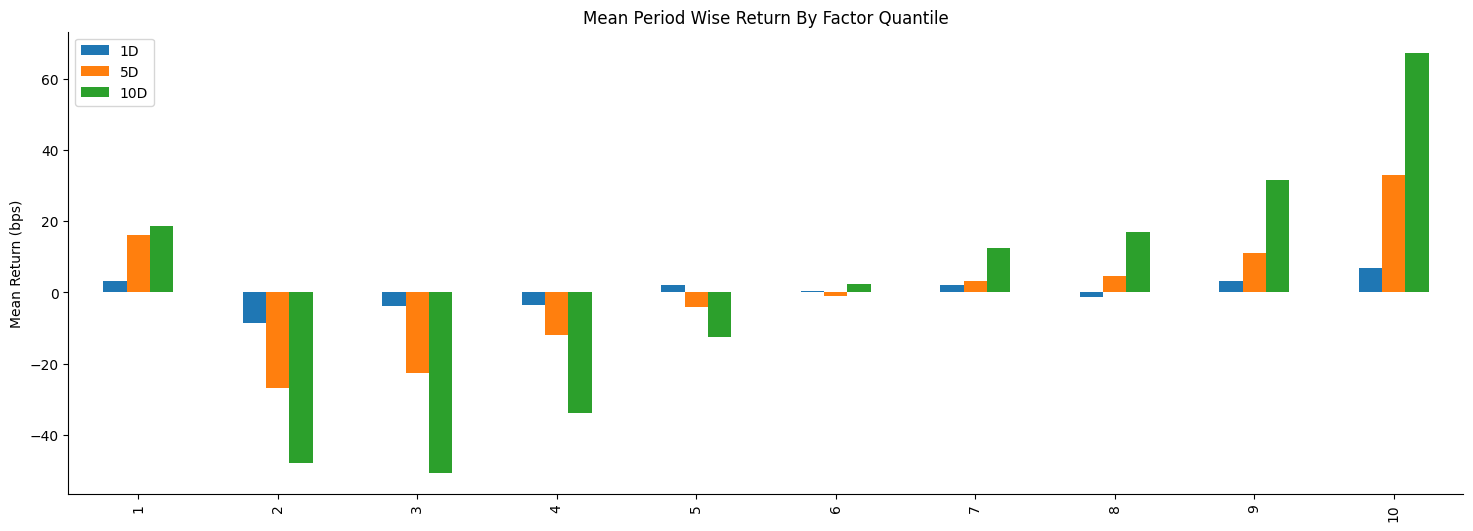

In [16]:
import seaborn as sns
from alphalens.plotting import plot_quantile_returns_bar

mean_return_by_q_daily, std_err = mean_return_by_quantile(
    factor_data, by_date=False)
plot_quantile_returns_bar(mean_return_by_q_daily)
sns.despine()

NameError: name 'sns' is not defined

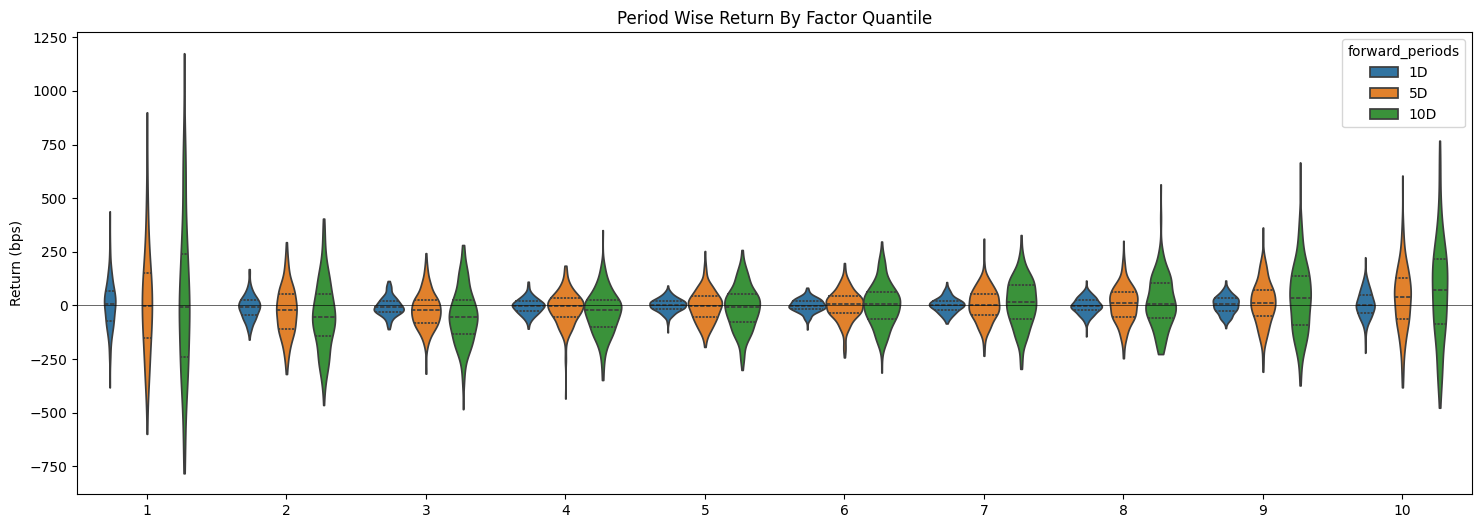

In [15]:
from alphalens.plotting import plot_quantile_returns_violin

mean_return_by_q_daily, std_err = mean_return_by_quantile(
    factor_data, by_date=True)
plot_quantile_returns_violin(mean_return_by_q_daily)
sns.despine()

[<Axes: title={'center': 'Top Minus Bottom Quantile Mean Return (1D Period Forward Return)'}, ylabel='Difference In Quantile Mean Return (bps)'>,
 <Axes: title={'center': 'Top Minus Bottom Quantile Mean Return (5D Period Forward Return)'}, ylabel='Difference In Quantile Mean Return (bps)'>,
 <Axes: title={'center': 'Top Minus Bottom Quantile Mean Return (10D Period Forward Return)'}, ylabel='Difference In Quantile Mean Return (bps)'>]

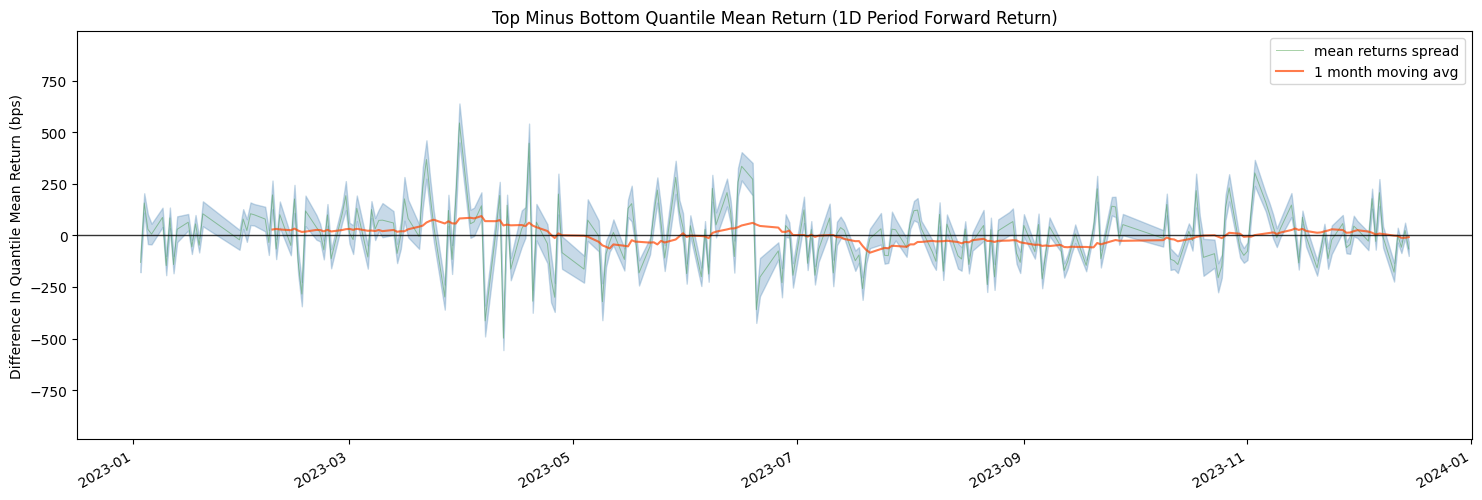

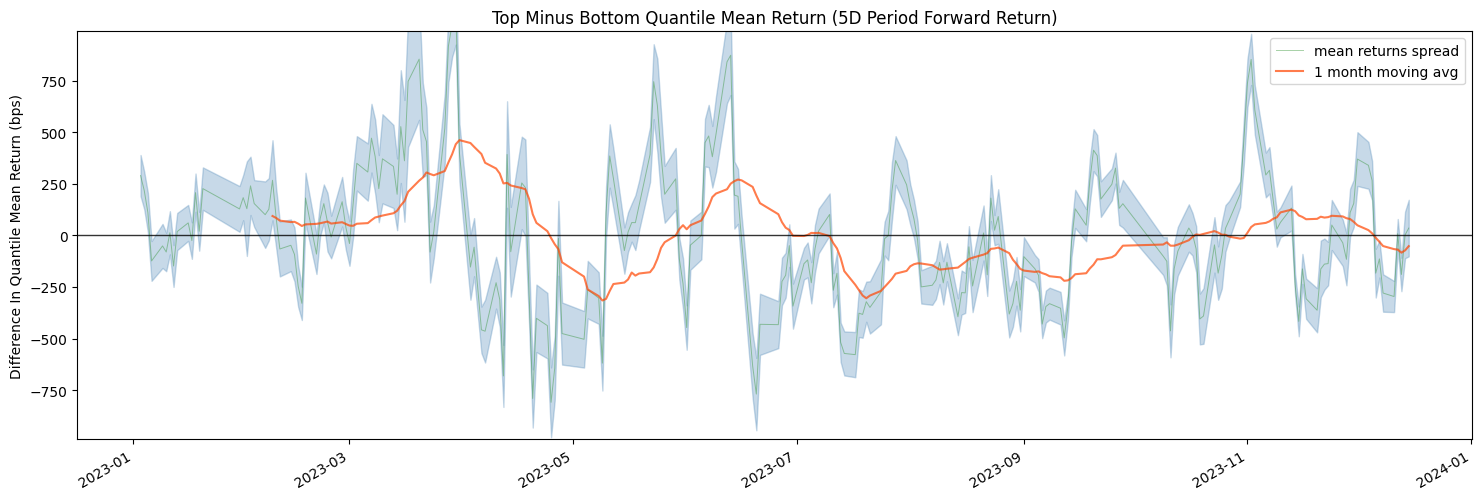

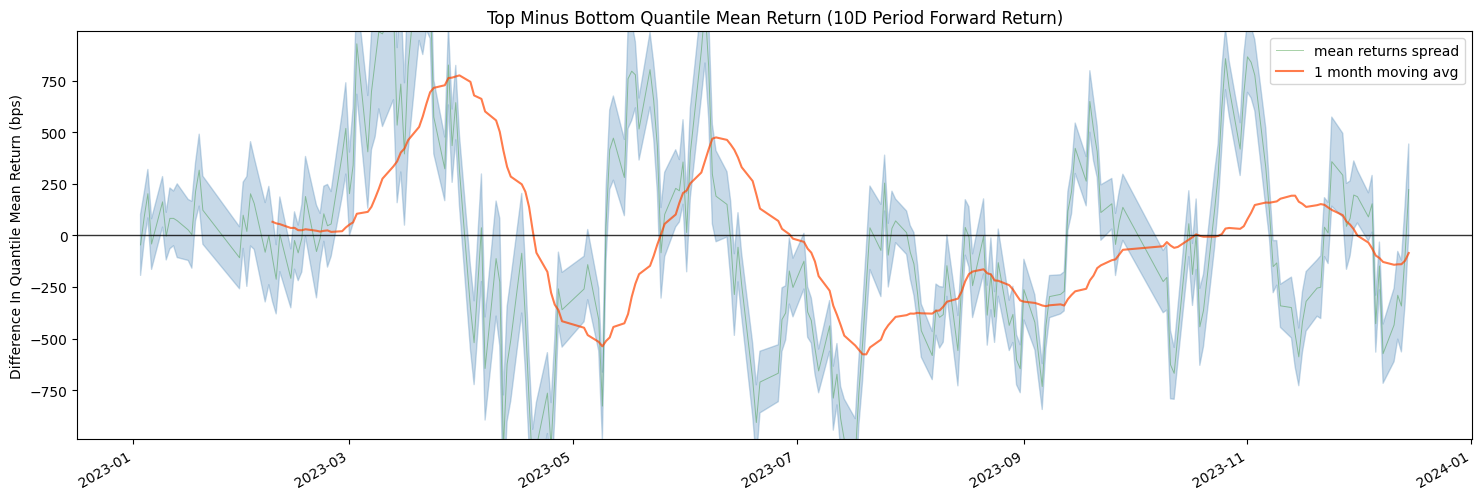

In [14]:
from alphalens.performance import compute_mean_returns_spread
from alphalens.plotting import plot_mean_quantile_returns_spread_time_series

qrs, ses = compute_mean_returns_spread(mean_return_by_q_daily,upper_quant=1, lower_quant=9,std_err=std_err)

plot_mean_quantile_returns_spread_time_series(qrs, ses)


<Axes: title={'center': 'Cumulative Return by Quantile\n                    (1D Period Forward Return)'}, ylabel='Log Cumulative Returns'>

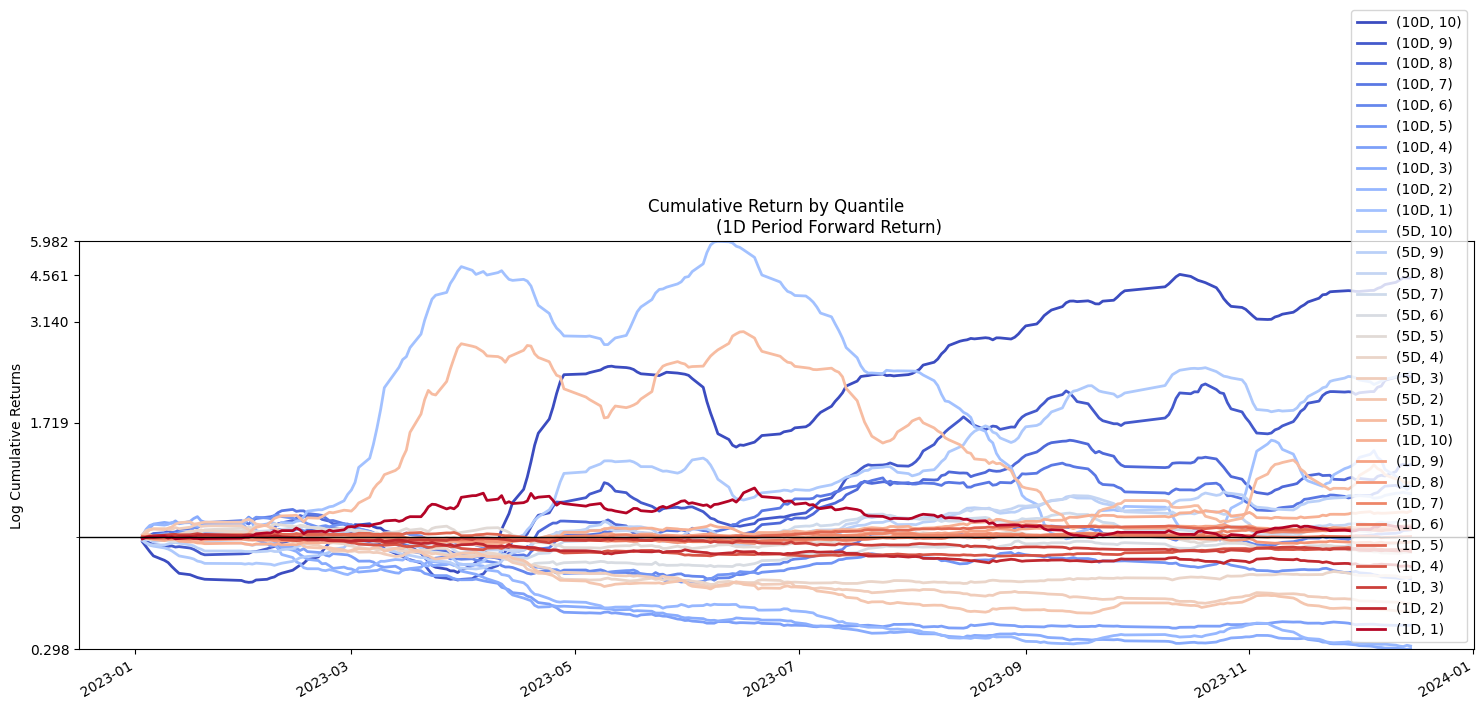

In [13]:
from alphalens.plotting import plot_cumulative_returns_by_quantile

mean_return_by_q_daily, std_err = mean_return_by_quantile(
    factor_data, by_date=True)
plot_cumulative_returns_by_quantile(mean_return_by_q_daily, period='1D')

## 计算alpha beta时的问题

In [45]:
from alphalens.performance import factor_alpha_beta

factor_data = get_clean_factor_and_forward_returns(factor, prices, bins=None, quantiles=10)
ab = factor_alpha_beta(factor_data)
ab

,1D,5D,10D
Ann. alpha,0.027455,0.058458,0.022515
beta,0.353804,0.207438,0.173700


In [7]:
from alphalens.performance import factor_alpha_beta

factor_data = get_clean_factor_and_forward_returns(factor, prices, bins=None, quantiles=10)

factor_data.factor = max(factor_data.factor) - factor_data.factor
ab = factor_alpha_beta(factor_data, demeaned=False)
ab

Dropped 4.1% entries from factor data: 4.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


,1D,5D,10D
Ann. alpha,-0.000293,-0.000552,-0.000196
beta,0.996346,0.997621,0.997872


## 演示alphalens中factor_weights的算法

In [53]:
tm = datetime.datetime(2023, 1, 1, 0)
df = pd.DataFrame([
    (tm, "A", 0.01, 1),
    (tm, "B", 0.02, 2),
    (tm, "C", 0.03, 3),
    (tm, "D", 0.04, 4)
], columns=["date", "asset", "1D", "factor"])

sample_factor_data = df.set_index(["date", "asset"])
sample_factor_data


1D  factor
date       asset              
2023-01-01 A      0.01       1
           B      0.02       2
           C      0.03       3
           D      0.04       4

In [17]:
from alphalens.performance import factor_weights
factor_weights(sample_factor_data, demeaned=False)

NameError: name 'sample_factor_data' is not defined

现在，我们修改一下factor，然后仅以单边做多的方式来计算其alpha和beta:

In [19]:
from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens.performance import factor_alpha_beta

factor_data = get_clean_factor_and_forward_returns(factor, prices, bins=None, quantiles=10)

factor_data.factor = 1 / factor_data.factor

factor_alpha_beta(factor_data,demeaned=False)

Dropped 4.1% entries from factor data: 4.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


,1D,5D,10D
Ann. alpha,0.017110,0.042078,0.012837
beta,1.282106,1.166979,1.135038


Dropped 4.1% entries from factor data: 4.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


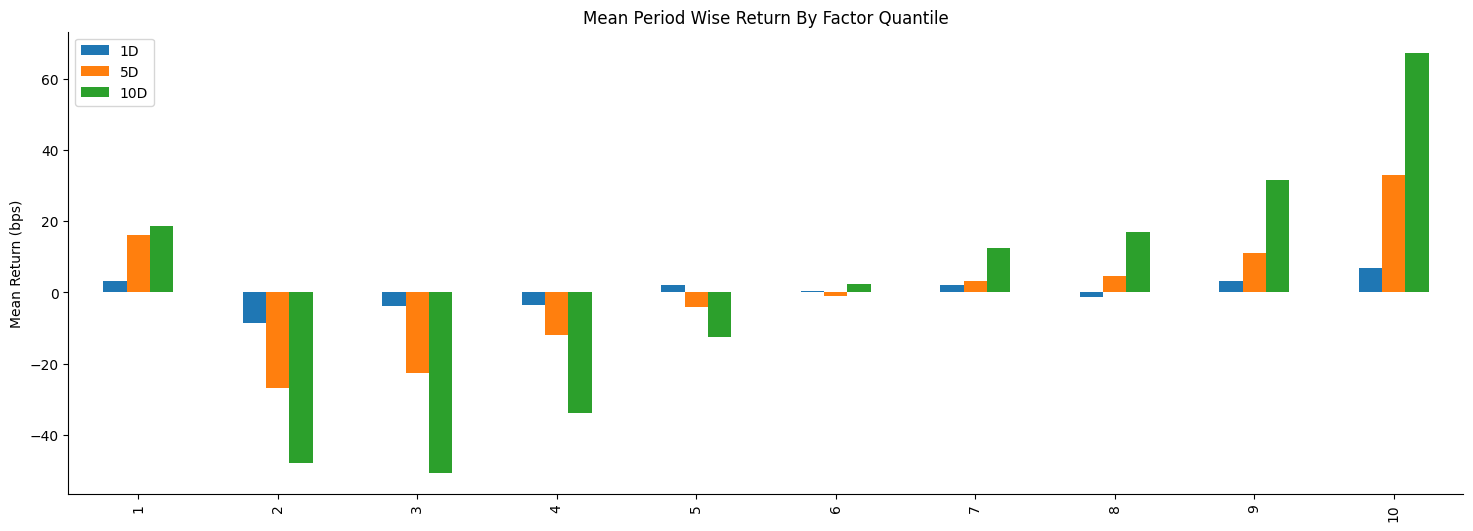

In [20]:
start = datetime.date(2023, 1, 3)
end = datetime.date(2023, 12, 31)
factor, prices = prepare_data(secs, start, end)

factor.factor = 1 / factor.factor

factor_data = get_clean_factor_and_forward_returns(factor, prices, bins=None, quantiles=10)

mean_return_by_q_daily, std_err = mean_return_by_quantile(
    factor_data, by_date=False)
plot_quantile_returns_bar(mean_return_by_q_daily)
sns.despine()

## IC

In [21]:
from alphalens.performance import factor_information_coefficient
ic = factor_information_coefficient(factor_data)

ic.describe()

,1D,5D,10D
count,232.000000,232.000000,232.000000
mean,0.058342,0.073489,0.094943
std,0.199800,0.195882,0.198105
min,-0.492946,-0.507912,-0.459957
25%,-0.079991,-0.064536,-0.040987
50%,0.043588,0.090376,0.091369
75%,0.213787,0.225248,0.273625
max,0.526797,0.519218,0.452951


array([<Axes: title={'center': '1D Period Forward Return Information Coefficient (IC)'}, ylabel='IC'>,
       <Axes: title={'center': '5D Period Forward Return Information Coefficient (IC)'}, ylabel='IC'>,
       <Axes: title={'center': '10D Period Forward Return Information Coefficient (IC)'}, ylabel='IC'>],
      dtype=object)

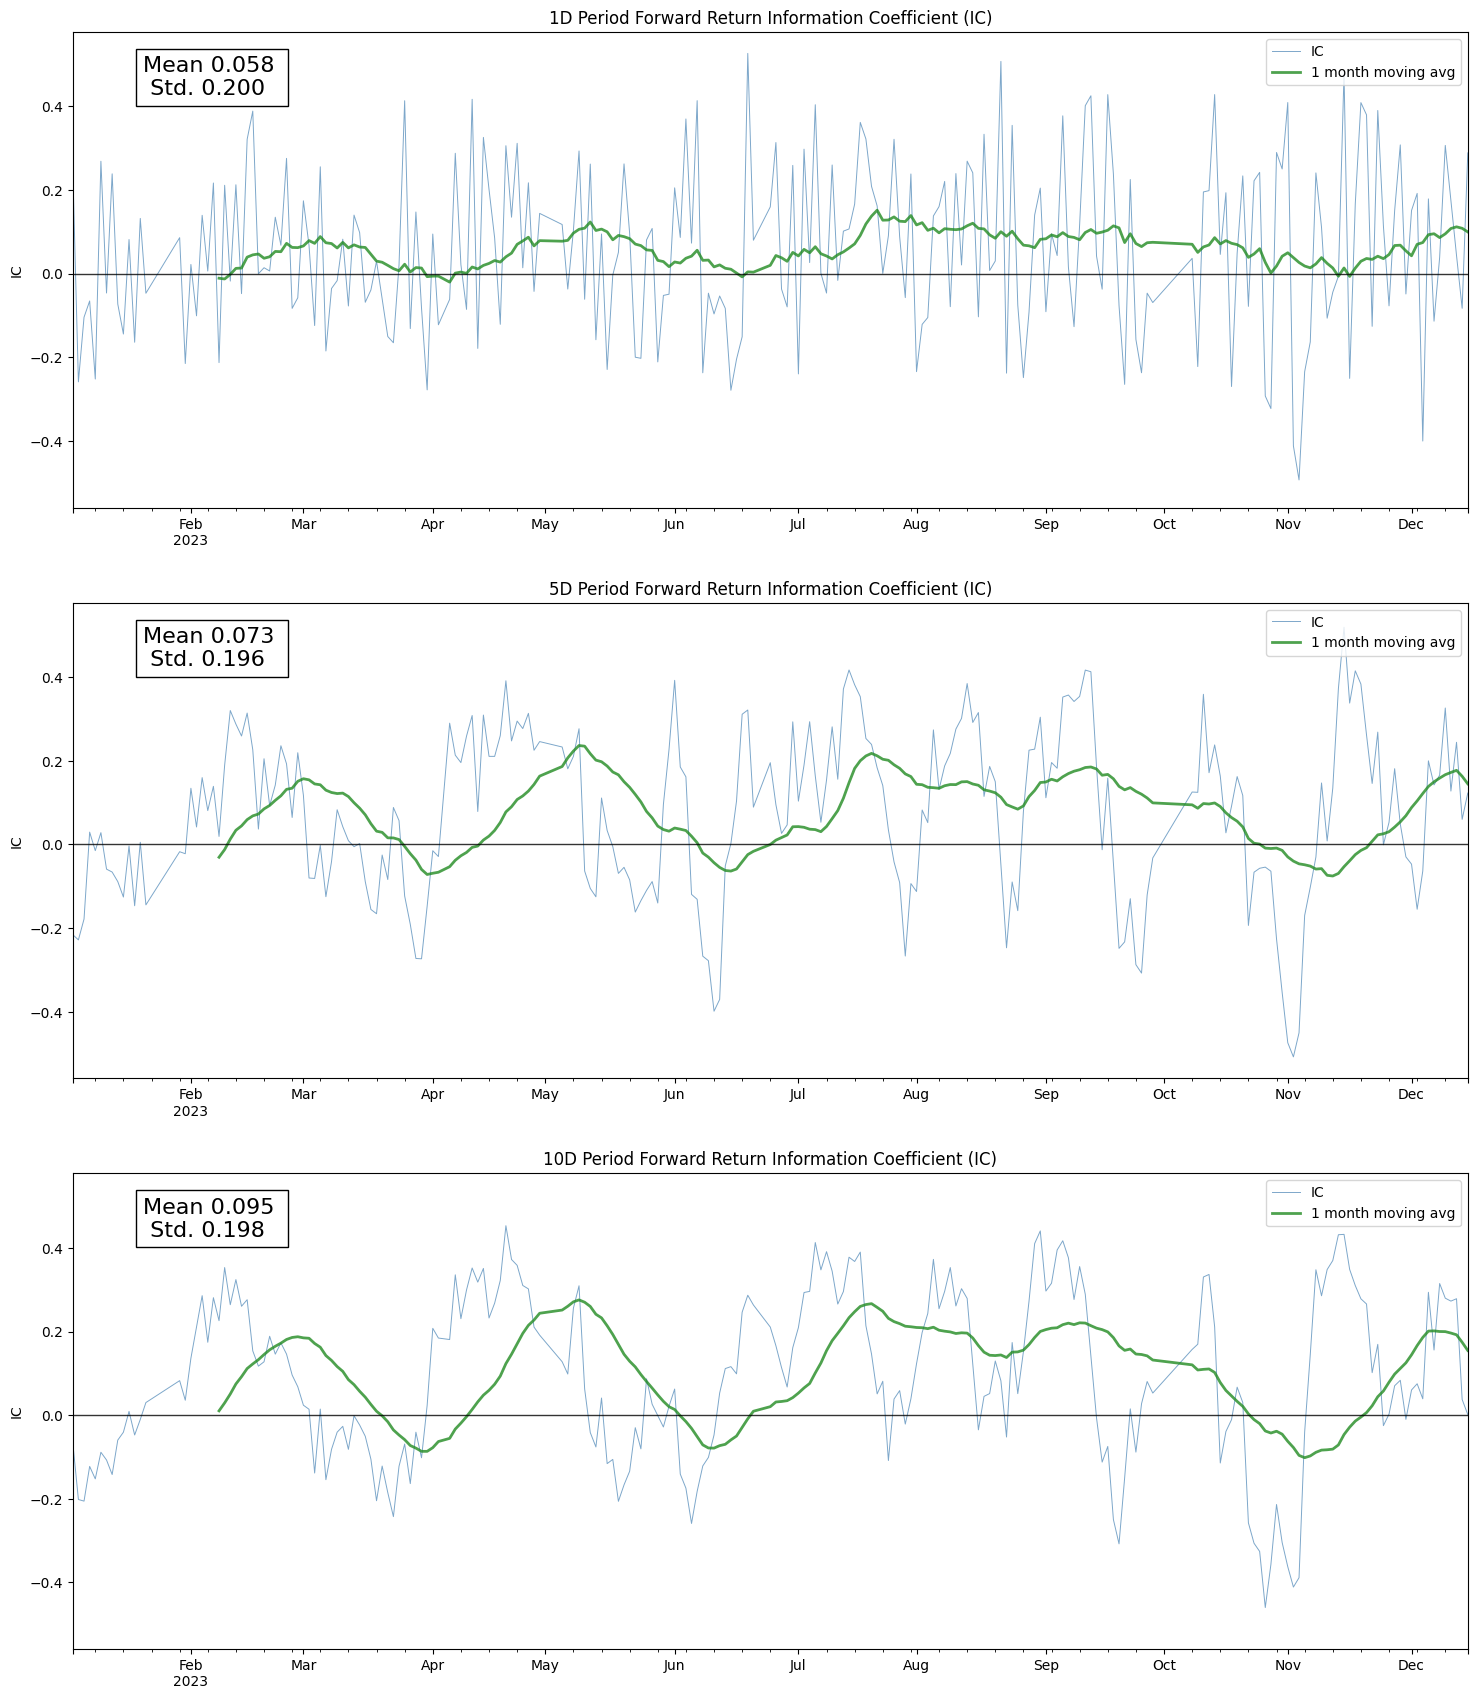

In [11]:
from alphalens.plotting import plot_ic_ts

plot_ic_ts(ic)

IC直方图

array([<Axes: title={'center': '1D Period IC'}, xlabel='IC', ylabel='Count'>,
       <Axes: title={'center': '5D Period IC'}, xlabel='IC', ylabel='Count'>,
       <Axes: title={'center': '10D Period IC'}, xlabel='IC', ylabel='Count'>],
      dtype=object)

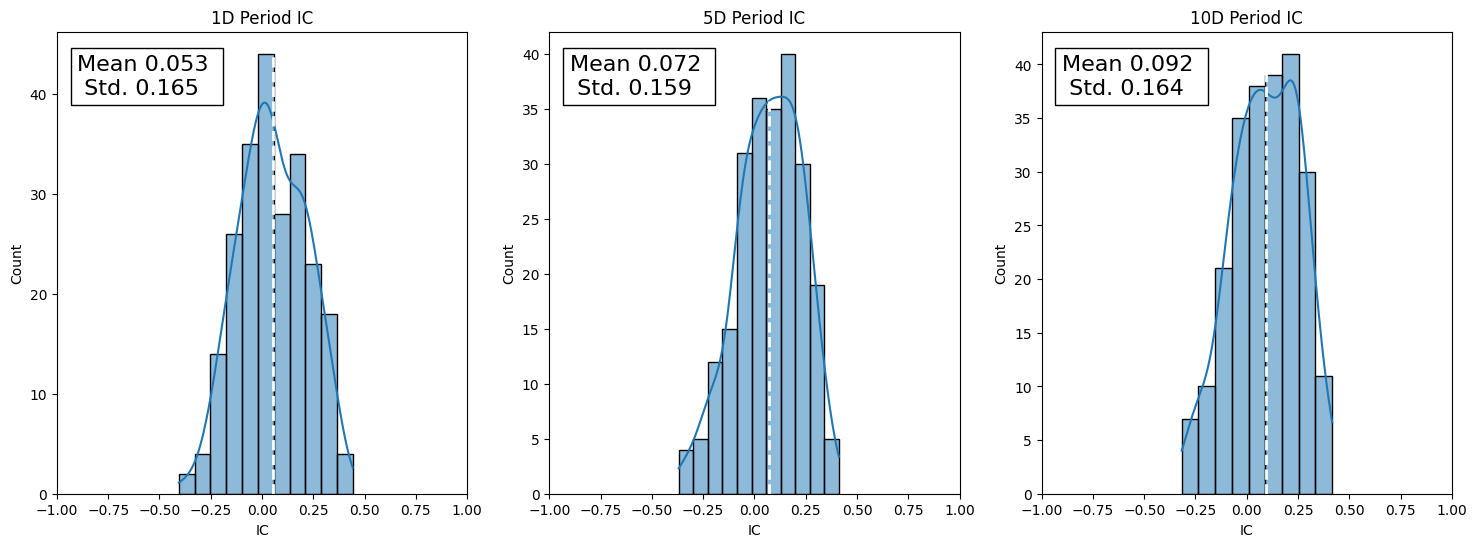

In [35]:
from alphalens.plotting import plot_ic_hist

plot_ic_hist(ic)

QQ图

array([<Axes: title={'center': '1D Period IC Normal Dist. Q-Q'}, xlabel='Normal Distribution Quantile', ylabel='Observed Quantile'>,
       <Axes: title={'center': '5D Period IC Normal Dist. Q-Q'}, xlabel='Normal Distribution Quantile', ylabel='Observed Quantile'>,
       <Axes: title={'center': '10D Period IC Normal Dist. Q-Q'}, xlabel='Normal Distribution Quantile', ylabel='Observed Quantile'>],
      dtype=object)

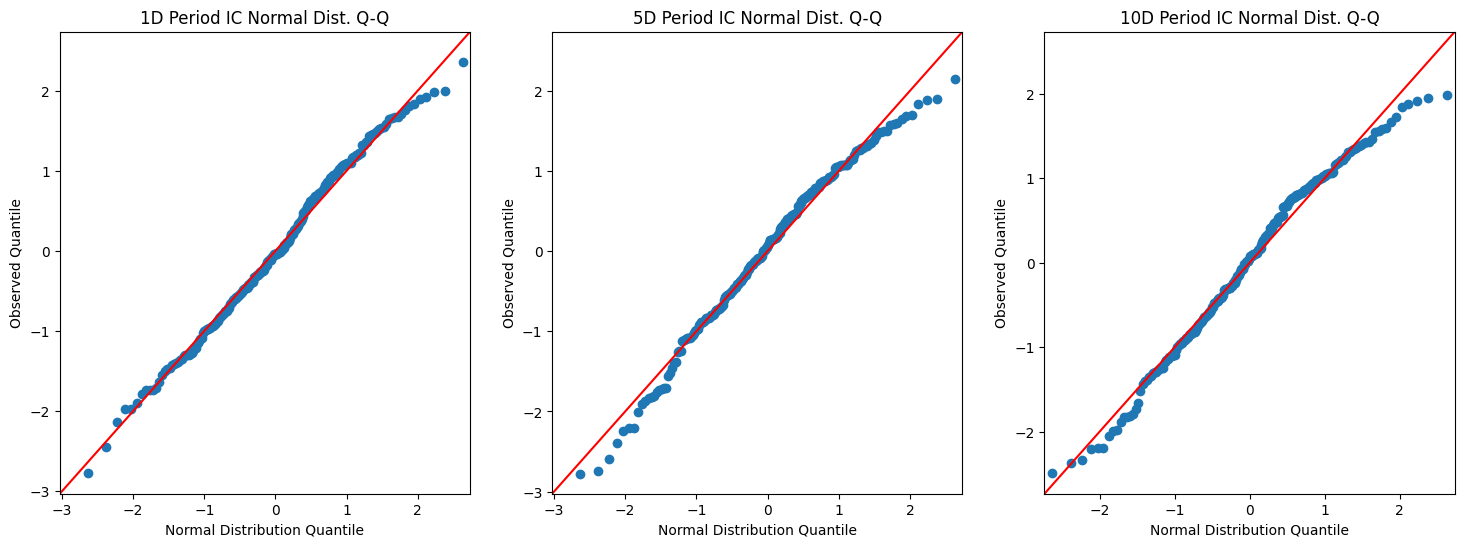

In [37]:
from alphalens.plotting import plot_ic_qq

plot_ic_qq(ic)